In [1]:
import torch
from torch.utils.data import Dataset, random_split
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os.path
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
device = torch.device('mps')

In [3]:
# Data class for taxi
class taxiData(Dataset):
  def __init__(self, csv_file):
    if os.path.isfile('cached_dataframe.pkl'):
      df = pd.read_pickle('cached_dataframe.pkl')
    else:
      df = pd.read_csv(csv_file)
      df.to_pickle('cached_dataframe.pkl')
    all_xy = df.to_numpy()
    
#    tmp_x = all_xy[:,0:7]
 
    call_type_data =    np.array(all_xy[:,0:66]     )
    taxi_id_data =      np.array(all_xy[:,66:516]   )
    month_data =        np.array(all_xy[:,516:528]  )
    weekday_data =      np.array(all_xy[:,528:535]  )
    time_data =         np.array(all_xy[:,535:536]  , dtype=np.float32)
    daytype_data =      np.array(all_xy[:,536:539]  )
    triptime_data =     np.array(all_xy[:,539]      , dtype=np.float32)

    #print(np.concatenate([time_data, daytype_data], axis=1))

    all_data = torch.tensor(all_xy[:,0:539], dtype=torch.float32)
    tmp_x = all_data

#    tmp_x = torch.unsqueeze(all_data, 1)
#    tmp_x = tmp_x.repeat(1, 2, 1)
#    tmp_x = all_data.repeat(1, 2)

    tmp_x = tmp_x.to(device)
    print(tmp_x.shape)

#    print(tmp_x)
#    print(tmp_x.shape)
#    print(tmp_x[0].shape)
#    print(tmp_x.shape)

    #tmp_x = all_xy[:,0:539]
    #tmp_y = all_xy[:,539]
#    print(tmp_x)
#    print(tmp_y)

    tmp_y = triptime_data
    self.x = tmp_x.to(device)

#    self.x = torch.tensor(tmp_x, dtype=torch.float32).to(device)
#    self.x = torch.tensor(tmp_x).to(device)

    print(self.x)
    self.y = torch.tensor(tmp_y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

taxi_train = taxiData('outfile.csv')
print(taxi_train)

torch.Size([1710660, 539])
tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], device='mps:0')


In [4]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(taxi_train, batch_size=batch_size, shuffle=True)

In [5]:
layer_size = 2156
model = nn.Sequential(
    nn.Linear(539, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.ReLU(),
    nn.Linear(layer_size, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.ReLU(),
    nn.Linear(layer_size, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.ReLU(),
    nn.Linear(layer_size, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.ReLU(),
    nn.Linear(layer_size, 1)
)

In [6]:
num_parameters = sum(p.numel() for p in model.parameters())
print('Number of parameters: {}'.format(num_parameters))

Number of parameters: 15135121


In [7]:
model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=539, out_features=2156, bias=True)
  (1): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=2156, out_features=2156, bias=True)
  (4): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=2156, out_features=2156, bias=True)
  (7): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=2156, out_features=2156, bias=True)
  (10): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=2156, out_features=1, bias=True)
)


In [8]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.00000001)

In [9]:
losses = []

epochs = 100
for epoch in tqdm(range(epochs)):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
#    print(i, data)
    params, trip_time = data[0].to(device), data[1].to(device)
    trip_time = trip_time.float()
#    params, trip_time = params.float(), trip_time.float()
    trip_time = trip_time.reshape((trip_time.shape[0], 1))
    '''
    print(params)
    print(params.shape)
    print(trip_time)
    print(trip_time.shape)
    '''

    optimizer.zero_grad()
    params = params.to(torch.float)
    outputs = model(params)
#    print(outputs)
    loss = loss_fn(outputs, trip_time)
    running_loss += loss.item()
    loss.backward()
    model.float()
    optimizer.step()

#    if i % 2000 == 1999:    # print every 2000 mini-batches
#       print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.7f}')
  print(f'[{epoch + 1}] loss: {running_loss / i:.13f}')
  losses.append(running_loss)

PATH = './jun8_100am.pth'
torch.save(model.state_dict(), PATH)

print("======= DONE =======")

  1%|          | 1/100 [02:07<3:30:27, 127.55s/it]

[1] loss: 956853.6765213446924


  2%|▏         | 2/100 [04:15<3:28:31, 127.66s/it]

[2] loss: 860255.0639895427739


  3%|▎         | 3/100 [06:22<3:26:25, 127.68s/it]

[3] loss: 759456.1107698387932


  4%|▍         | 4/100 [08:30<3:24:10, 127.61s/it]

[4] loss: 671616.7817843179218


  5%|▌         | 5/100 [10:38<3:22:05, 127.64s/it]

[5] loss: 591366.5957142323023


  6%|▌         | 6/100 [12:45<3:20:02, 127.68s/it]

[6] loss: 531288.5687492984580


  7%|▋         | 7/100 [14:50<3:16:11, 126.57s/it]

[7] loss: 488531.0330920523265


  8%|▊         | 8/100 [16:49<3:10:18, 124.12s/it]

[8] loss: 459090.5618318102788


  9%|▉         | 9/100 [18:49<3:06:18, 122.84s/it]

[9] loss: 439231.5561811349471


 10%|█         | 10/100 [20:49<3:02:56, 121.96s/it]

[10] loss: 426395.9107823490631


 11%|█         | 11/100 [22:49<3:00:01, 121.37s/it]

[11] loss: 417636.1461359576206


 12%|█▏        | 12/100 [24:49<2:57:22, 120.94s/it]

[12] loss: 411718.3524013908464


 13%|█▎        | 13/100 [26:48<2:54:53, 120.61s/it]

[13] loss: 408140.3706190605299


 14%|█▍        | 14/100 [28:48<2:52:34, 120.41s/it]

[14] loss: 404647.5574853618164


 15%|█▌        | 15/100 [30:48<2:50:26, 120.31s/it]

[15] loss: 402161.9439807973104


 16%|█▌        | 16/100 [32:48<2:48:06, 120.08s/it]

[16] loss: 399525.8316851709969


 17%|█▋        | 17/100 [34:47<2:45:48, 119.86s/it]

[17] loss: 397408.8171118536848


 18%|█▊        | 18/100 [36:47<2:43:53, 119.92s/it]

[18] loss: 395042.4369300219114


 19%|█▉        | 19/100 [38:48<2:41:59, 119.99s/it]

[19] loss: 393329.9857856227318


 20%|██        | 20/100 [40:48<2:39:57, 119.97s/it]

[20] loss: 391236.7893530426663


 21%|██        | 21/100 [42:52<2:39:52, 121.43s/it]

[21] loss: 389033.1108586968621


 22%|██▏       | 22/100 [45:00<2:40:14, 123.26s/it]

[22] loss: 386794.7274376356509


 23%|██▎       | 23/100 [47:07<2:39:42, 124.45s/it]

[23] loss: 385654.2340394436615


 24%|██▍       | 24/100 [49:15<2:38:50, 125.41s/it]

[24] loss: 383678.3078881463152


 25%|██▌       | 25/100 [51:22<2:37:33, 126.05s/it]

[25] loss: 381699.1282824893133


 26%|██▌       | 26/100 [53:28<2:35:22, 125.98s/it]

[26] loss: 379739.1855831197463


 27%|██▋       | 27/100 [55:27<2:30:50, 123.98s/it]

[27] loss: 377317.5402714381926


 28%|██▊       | 28/100 [57:27<2:27:19, 122.77s/it]

[28] loss: 376503.5175284345751


 29%|██▉       | 29/100 [59:27<2:24:18, 121.94s/it]

[29] loss: 374726.3262554717949


 30%|███       | 30/100 [1:01:27<2:21:35, 121.37s/it]

[30] loss: 372399.0923218394746


 31%|███       | 31/100 [1:03:27<2:19:05, 120.94s/it]

[31] loss: 371053.2849791183253


 32%|███▏      | 32/100 [1:05:26<2:16:08, 120.13s/it]

[32] loss: 369690.1092007912812


 33%|███▎      | 33/100 [1:07:25<2:14:03, 120.06s/it]

[33] loss: 367974.0458198097767


 34%|███▍      | 34/100 [1:09:26<2:12:04, 120.07s/it]

[34] loss: 365807.5425677192397


 35%|███▌      | 35/100 [1:11:26<2:10:03, 120.05s/it]

[35] loss: 364251.8719133493141


 36%|███▌      | 36/100 [1:13:26<2:08:02, 120.04s/it]

[36] loss: 362641.4404790856061


 37%|███▋      | 37/100 [1:15:25<2:05:59, 120.00s/it]

[37] loss: 360901.8729884157074


 38%|███▊      | 38/100 [1:17:26<2:04:08, 120.14s/it]

[38] loss: 359985.2776717066299


 39%|███▉      | 39/100 [1:19:26<2:02:02, 120.04s/it]

[39] loss: 358468.0692070347723


 40%|████      | 40/100 [1:21:26<2:00:00, 120.00s/it]

[40] loss: 357541.3978868134436


 41%|████      | 41/100 [1:23:26<1:58:01, 120.03s/it]

[41] loss: 355448.7881557963556


 42%|████▏     | 42/100 [1:25:25<1:55:44, 119.73s/it]

[42] loss: 354837.8413566765375


 43%|████▎     | 43/100 [1:27:24<1:53:33, 119.54s/it]

[43] loss: 351750.5465493817464


 44%|████▍     | 44/100 [1:29:24<1:51:42, 119.68s/it]

[44] loss: 350798.6857947424287


 45%|████▌     | 45/100 [1:31:24<1:49:45, 119.74s/it]

[45] loss: 349293.6785539743141


 46%|████▌     | 46/100 [1:33:24<1:47:50, 119.82s/it]

[46] loss: 347894.6251981770038


 47%|████▋     | 47/100 [1:35:24<1:45:52, 119.86s/it]

[47] loss: 346683.3895218731486


 48%|████▊     | 48/100 [1:37:24<1:43:53, 119.87s/it]

[48] loss: 345417.8971525647212


 49%|████▉     | 49/100 [1:39:24<1:41:54, 119.88s/it]

[49] loss: 344037.5641877198359


 50%|█████     | 50/100 [1:41:23<1:39:54, 119.89s/it]

[50] loss: 342574.7642757595167


 51%|█████     | 51/100 [1:43:23<1:37:55, 119.92s/it]

[51] loss: 340796.8787677014479


 52%|█████▏    | 52/100 [1:45:23<1:35:53, 119.87s/it]

[52] loss: 341135.6684796842164


 53%|█████▎    | 53/100 [1:47:22<1:33:44, 119.66s/it]

[53] loss: 338515.3226216420881


 54%|█████▍    | 54/100 [1:49:22<1:31:47, 119.73s/it]

[54] loss: 336639.8981346808723


 55%|█████▌    | 55/100 [1:51:22<1:29:50, 119.79s/it]

[55] loss: 336625.4216452550027


 56%|█████▌    | 56/100 [1:53:22<1:27:54, 119.87s/it]

[56] loss: 335085.1060387280886


 57%|█████▋    | 57/100 [1:55:22<1:25:56, 119.93s/it]

[57] loss: 334341.4671558150440


 58%|█████▊    | 58/100 [1:57:22<1:23:57, 119.94s/it]

[58] loss: 331379.1935616441770


 59%|█████▉    | 59/100 [1:59:22<1:21:57, 119.95s/it]

[59] loss: 331483.2475967384526


 60%|██████    | 60/100 [2:01:22<1:19:57, 119.95s/it]

[60] loss: 330230.5162861745921


 61%|██████    | 61/100 [2:03:22<1:17:57, 119.94s/it]

[61] loss: 328374.1526214316254


 62%|██████▏   | 62/100 [2:05:22<1:15:58, 119.95s/it]

[62] loss: 327689.4531805363367


 63%|██████▎   | 63/100 [2:07:21<1:13:46, 119.63s/it]

[63] loss: 325450.4693597304286


 64%|██████▍   | 64/100 [2:09:20<1:11:37, 119.36s/it]

[64] loss: 326073.1584369621705


 65%|██████▌   | 65/100 [2:11:20<1:09:44, 119.56s/it]

[65] loss: 324819.7098975091940


 66%|██████▌   | 66/100 [2:13:20<1:07:49, 119.68s/it]

[66] loss: 324146.2520191840013


 67%|██████▋   | 67/100 [2:15:20<1:05:52, 119.78s/it]

[67] loss: 322873.9260221022996


 68%|██████▊   | 68/100 [2:17:20<1:03:55, 119.85s/it]

[68] loss: 321633.7559201726690


 69%|██████▉   | 69/100 [2:19:19<1:01:49, 119.65s/it]

[69] loss: 320251.8586103524431


 70%|███████   | 70/100 [2:21:19<59:48, 119.63s/it]  

[70] loss: 320655.2439968151157


 71%|███████   | 71/100 [2:23:18<57:46, 119.52s/it]

[71] loss: 318655.2022188809351


 72%|███████▏  | 72/100 [2:25:17<55:42, 119.37s/it]

[72] loss: 317855.1090850419132


 73%|███████▎  | 73/100 [2:27:17<53:48, 119.56s/it]

[73] loss: 317223.6437174966559


 74%|███████▍  | 74/100 [2:29:17<51:51, 119.66s/it]

[74] loss: 315593.9522902012686


 75%|███████▌  | 75/100 [2:31:17<49:53, 119.75s/it]

[75] loss: 316213.5917764142505


 76%|███████▌  | 76/100 [2:33:17<47:55, 119.82s/it]

[76] loss: 314412.5909831216559


 77%|███████▋  | 77/100 [2:35:17<45:56, 119.87s/it]

[77] loss: 312214.5130849436973


 78%|███████▊  | 78/100 [2:37:17<43:57, 119.88s/it]

[78] loss: 313245.6987230152008


 79%|███████▉  | 79/100 [2:39:16<41:57, 119.87s/it]

[79] loss: 312333.9230681541958


 80%|████████  | 80/100 [2:41:16<39:58, 119.92s/it]

[80] loss: 310216.8864124232787


 81%|████████  | 81/100 [2:43:16<37:58, 119.91s/it]

[81] loss: 310850.4477841589251


 82%|████████▏ | 82/100 [2:45:15<35:50, 119.48s/it]

[82] loss: 309438.2880242629326


 83%|████████▎ | 83/100 [2:47:14<33:50, 119.44s/it]

[83] loss: 308668.7932066793437


 84%|████████▍ | 84/100 [2:49:14<31:53, 119.58s/it]

[84] loss: 309287.4023776563699


 85%|████████▌ | 85/100 [2:51:14<29:55, 119.70s/it]

[85] loss: 307607.6469023589743


 86%|████████▌ | 86/100 [2:53:14<27:56, 119.78s/it]

[86] loss: 307010.2704356152681


 87%|████████▋ | 87/100 [2:55:14<25:57, 119.82s/it]

[87] loss: 306458.7415070338175


 88%|████████▊ | 88/100 [2:57:14<23:58, 119.86s/it]

[88] loss: 304604.0931309160660


 89%|████████▉ | 89/100 [2:59:14<21:58, 119.85s/it]

[89] loss: 304686.3361350924242


 90%|█████████ | 90/100 [3:01:14<19:58, 119.88s/it]

[90] loss: 303552.0800483107450


 91%|█████████ | 91/100 [3:03:14<17:59, 119.91s/it]

[91] loss: 302678.8216851241887


 92%|█████████▏| 92/100 [3:05:13<15:58, 119.79s/it]

[92] loss: 301628.4365856966469


 93%|█████████▎| 93/100 [3:07:12<13:57, 119.66s/it]

[93] loss: 301413.9592275656760


 94%|█████████▍| 94/100 [3:09:12<11:58, 119.75s/it]

[94] loss: 301316.7699205888784


 95%|█████████▌| 95/100 [3:11:12<09:59, 119.83s/it]

[95] loss: 300581.6278978271876


 96%|█████████▌| 96/100 [3:13:12<07:59, 119.87s/it]

[96] loss: 298998.7969393052044


 97%|█████████▋| 97/100 [3:15:11<05:58, 119.44s/it]

[97] loss: 300058.5555456824368


 98%|█████████▊| 98/100 [3:17:10<03:59, 119.50s/it]

[98] loss: 297744.6379756248207


 99%|█████████▉| 99/100 [3:19:10<01:59, 119.56s/it]

[99] loss: 297864.8961453111260


100%|██████████| 100/100 [3:21:10<00:00, 120.70s/it]

[100] loss: 297589.0513874728931
======= DONE =======


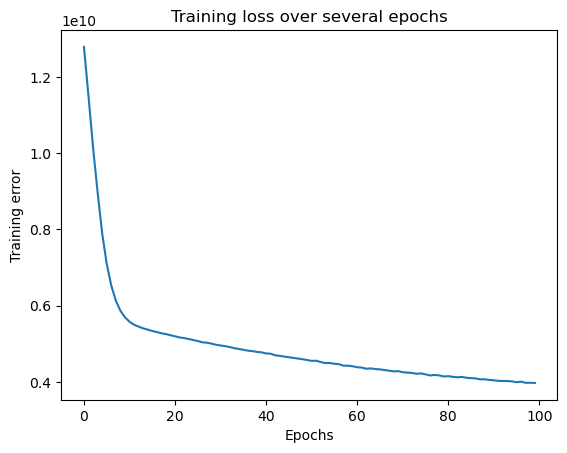

In [10]:
plt.plot(range(0, epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Training error')
plt.title('Training loss over several epochs')
plt.show()